# The Problem: XOR Classification
- Consider the logical operation XOR (Exclusive-or):

| bits | output |
|-|-|
| 1   0  | 1 |
| 0   1  | 1 |
| 0   0  | 0 |
| 1   1  | 0 |

- Can a linear model fit this function? Let's look at the graphical representation of the XOR function:
<img src="https://github.com/jbial/ml-tutorials/blob/master/neural_network/images/xor.png?raw=1" />

- Clearly the XOR is not **linearly separable**, it is **nonlinear**
- This kind of problem is perfect for a **neural network**

## Neural Networks
- How can we model neurons in the brain and computationally represent them?
<img src="https://github.com/jbial/ml-tutorials/blob/master/neural_network/images/neuron.png?raw=1" />

- From this basic building block we can begin to build simple neural networks. The XOR neural network looks like:

<img src="https://github.com/jbial/ml-tutorials/blob/master/neural_network/images/xornn.png?raw=1" />

- For now, we use this graph representation of neural networks for ease of visualization, but it does not scale to larger networks. Remember that neural networks are really just functions that look like this:

$$ NN(x) = f(W_nf(W_{n-1}f(...f(W_1x + b_1)) + b_{n-1}) + b_n) $$

- Note that $ f(\cdot) $ **must** be nonlinear in order to model nonlinear functions, otherwise it's easy to show that if $ f(\cdot) $ is linear, then the entire neural network reduces to a linear model and were back to square one

In [7]:
# Import dependencies
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
# Set the random seed
np.random.seed(43252)

In [9]:
# Data generating function
def generate_data():
    """Generates bitpairs for the xor neural network
    """
    bitpairs = np.array([[1,0],
                         [0,1],
                         [0,0],
                         [1,1]])  # data
    xor_labels = np.array([[1],
                           [1],
                           [0],
                           [0]])  # labels
    return bitpairs, xor_labels

In [10]:
# Define the initalization scheme for the network
def get_parameters():
    """Generates weights for the XOR network sampled from the normal distribution
    """
    w = [2 * np.random.rand(2,2) - 1,
         2 * np.random.rand(2,1) - 1]
    b = [2 * np.random.rand(2) - 1,
         2 * np.random.rand(1) - 1]
    return w, b

In [11]:
# Debugging tool for checking tensor shapes
def print_shapes(ls, name):
    """Helper to print shapes of elements in a list
    """
    print(f"{name}: {[l.shape for l in ls]}")

## Sigmoid Function
- The sigmoid functions maps any real input to a probability value $ \sigma \in (0, 1) $  

$$ \sigma(x) = \frac{1}{1 + \exp(-x)} $$  
  
- We use the sigmoid function for the XOR neural network because our goal is to predict values in the set $ \{0, 1\} $, and the sigmoid function allows us to output a continuous approximation of this discrete set  
- Techincally we can use different activation functions for every layer (as long as the output is in $ [0, 1] $ ), but for the purposes of this tutorial, we will use the sigmoid function throughout

In [12]:
# Define the activation function
def sigmoid(x, deriv=False):
    """Defines the sigmoid activation function and its derivative
    """
    if deriv:
        return sigmoid(x) * (1 - sigmoid(x))
    return 1 / (1 + np.exp(-x))

## Binary Cross-Entropy Function
- The cross entropy function is used as a distance measure between probability distributions
- The discrete version of cross entropy is as follows:

$$ H(\textbf{p}, \textbf{q}) = -\sum_{i = 1}^m q_i\log(p_i) $$

- Since we're predicting a single probability value, we can think of our discrete output distribution as $ [\sigma, 1 - \sigma] $, where $\sigma$ is the output from the neural network, and the discrete target distribution as $ [y, 1 - y] $ and thus, $ m = 2 $. So the cross entropy function reduces to the **binary cross entropy** function:  

$$ H(p, q) = -(q\log(p) + (1 - q)\log(1 - p)) $$

- Where p and q are the predicted and target distributions respectively. Our optimization objective is to minimize the binary cross entropy between the XOR labels and the network outputs

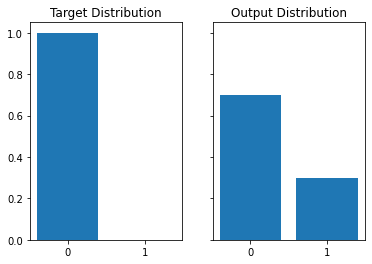

In [13]:
# visual example of the target and output distributions
q = [1, 0]
p = [0.7, 0.3]
fig, ax = plt.subplots(1, 2, sharey=True)
_ = (ax[0].set_title("Target Distribution"),
     ax[1].set_title("Output Distribution"),
     ax[0].set_xticks([0, 1]),
     ax[1].set_xticks([0, 1]),
     ax[0].bar([0, 1], q),
     ax[1].bar([0, 1], p))

In [14]:
# Define the loss function
def binary_xentropy(target, p, deriv=False):
    """Defines the binary cross entropy loss function and its derivative
    """
    if deriv:
        return (p - target) / (p * (1 - p))
    return -(target * np.log(p) + (1 - target) * np.log(1 - p))

## Shuffling
- In SGD (stochastic gradient descent), we make updates on the parameters over randomly shuffled **mini-batches**.  
  
  
- Why do we shuffle and batch, rather than computing gradients over the entire dataset once?  
    + For big datasets, this could be computationally intractable  
    + For non-convex functions or functions with many local minima, gradient descent could get stuck a bad minima  
  
  
- The stochasticity introduced by the random shuffling then batching in SGD allows our optimization procedure to make   noisy gradient updates, and possibly 'jump out' of bad local minima we land in

<img src="https://github.com/jbial/ml-tutorials/blob/master/neural_network/images/sgd.png?raw=1" alt="Drawing" style="width: 400px;"/>

In [16]:
a = np.random.randint(0, 5, 5)
print(a)
rand_ind = np.random.permutation(len(a))
print(rand_ind)
print(a[rand_ind])
def shuffle_and_batch(X, Y, batch_size):
    """Method to shuffle and batch training data
    """
    assert batch_size <= len(X), print("Batch size must be smaller than the dataset size")
    
    length = len(X)
    shuff_indices = np.random.permutation(length)
    x, y = X[shuff_indices], Y[shuff_indices]

    # Return a generator for the data
    return ((x[i:i + batch_size], y[i:i + batch_size]) for i in range(0, length, batch_size))

[0 1 4 2 3]
[3 4 2 0 1]
[2 3 4 0 1]


## The Forward Pass: How neural networks process data
- Neural networks process data through forward propogation i.e. sending the data input signal through all neurons
- The math for the forward propogation is simple:  
  
$$ z_j^{l} = \sum_{i = 1}^{n} a_i^{l - 1}w_{ij}^{l} + b_j^{l} $$  
  
   
$$ a_j^{l} = \sigma(z_j^l) $$

- In matrix-vector notation:

$$ \textbf{z}^{l} = \textbf{a}^{l - 1}\textbf{W}^l + \textbf{b}^l $$  

  
$$ \textbf{a}^{l} = \sigma(\textbf{z}^{l})$$

- Some call $\textbf{a}$ and $\textbf{z}$ the activation and pre-activation respectively

In [18]:
def feedforward(x, weights, biases):
    """Perform feed forward operation
    """
    zs, activations, d_activations = [], [x], []
    for w, b in zip(weights, biases):
        
        # compute and store the linear transformation
        z = activations[-1]@w + b
        zs.append(z)
        
        # compute and store the nonlinear transformation
        act = sigmoid(z) 
        activations.append(act)
        
        # compute the activation function derivatives for computing the error signals later
        d_activations.append(sigmoid(z, deriv=True))
    
    return zs, activations, d_activations

## The Backward Pass: The workhorse of neural network optimization
- At this point, we know how to use gradient descent to optimize parameters for a 'single' layer linear model, but how do we optimize a multi-layer neural network e.g. $ f(x) = \sigma(w_2\sigma(w_1x + b_1) + b_2) $ ?
- Thanks to Geoffrey Hinton, in 1986 he invented [an algorithm](https://www.iro.umontreal.ca/~vincentp/ift3395/lectures/backprop_old.pdf) to solve this problem called back-propogation
- Michael Nielsen has made an amazing modern tutorial on backpropogation [here](http://neuralnetworksanddeeplearning.com/chap2.html)  
  
  
- Our optimization objective is to find $ \nabla_\theta\mathcal{L} $ so that we can adjust the parameters $\theta$ in the direction that minimizes our loss function $\mathcal{L}$
- We define $\delta^l := \frac{\partial \mathcal{L}}{\partial \textbf{z}^l}$ as the derivative of the loss w.r.t the pre-activation in the $l$-th layer
- From Michael Nielsen's website there are four fundamental equations to backpropogation (proofs are provided on his website, two are left as an exercise)

\begin{equation}
\delta^{L} = \nabla_a{\mathcal{L}}\odot\sigma^\prime(\textbf{z}^L)
\end{equation}

\begin{equation}
\delta^{l} = (\delta^{l + 1}(w^{l + 1})^T)\odot\sigma^\prime(\textbf{z}^l)
\end{equation}

\begin{equation}
\frac{\partial{\mathcal{L}}}{\partial{w_{jk}^l}} = (a^{l-1})^T \delta_j^l
\end{equation}

\begin{equation}
\frac{\partial{\mathcal{L}}}{\partial{b_{j}^l}} = \delta_j^l
\end{equation}

In [29]:
def backprop(x, y, weights, biases):
    """Obtain gradients through backprop
    """
    # get the z values, activations, and activation derivatives 
    zs, activations, d_activations = feedforward(x, weights, biases)
    
    # Calculate error signal compute gradients for last layer weights and biases
    gradw, gradb = [0 for _ in weights], [0 for _ in biases]

    delta = binary_xentropy(y, activations[-1], deriv=True) * d_activations[-1]
    gradw[-1] = activations[-2].T@delta
    gradb[-1] = delta.mean(axis=0)

    # Compute gradients for rest of layers
    # Even though our NN is only 2 layers, it makes our code more general & extendable to bigger NNs 
    for layer in range(2, len(weights) + 1):
        
        # compute error signal using the higher layer's error signal
        delta = delta@weights[-layer + 1].T * d_activations[-layer]
        
        # compute gradients
        gradw[-layer] = activations[-(layer + 1)].T@delta
        gradb[-layer] = delta.mean(axis=0)
        
    return gradw, gradb

## SGD: A recap
- We've seen how to do gradient descent applied to linear regression for one-dimensional inputs, its a minor adjustment to handle multiple dimensional gradient updates:

\begin{equation}
W^l := W^l - \alpha\nabla_{W^l}\mathcal{L}
\end{equation}

\begin{equation}
b^l := b^l - \alpha\nabla_{b^l}\mathcal{L}
\end{equation}


In [20]:
def SGD(X, Y, batch_size, lr, weights, biases):
    """Performs stochastic gradient descent over mini batches
    """
    # Load data batches and train
    for x, y in shuffle_and_batch(X, Y, batch_size):

        # Obtain gradients and optimize with SGD
        weight_grads, bias_grads = backprop(x, y, weights, biases)
        
        # update parameters
        for i in range(len(weights)):
            weights[i] = weights[i] - lr * weight_grads[i]
            biases[i] = biases[i] - lr * bias_grads[i]

In [21]:
def train(dataset, weights, biases, epochs=100, lr=1e-3, batch_size=4):
    """Trains the XOR neural network with SGD
    """
    losses = []
    for epoch in range(epochs):

        # perform stochastic gradient through the network
        SGD(*dataset, batch_size, lr, weights, biases)

        _, activations, _ = feedforward(dataset[0], weights, biases)
        epoch_loss = binary_xentropy(dataset[1], activations[-1]).mean()
        losses.append(epoch_loss)
        if epoch % (epochs // 10) == 0:
            print(f"Running epoch {epoch:06d} - loss: {epoch_loss:.06f}")

    return losses

In [22]:
def predict(dataset, weights, biases):
    """Make predictions on the dataset with the trained network
    """
    X, _ = dataset
    _, activations, _ = feedforward(X, weights, biases)
    print("Truth table predictions")
    print("_______________________")
    for x, pred in zip(X, activations[-1]):
        print(f"{x[0]} {x[1]} | {pred[0]:.14f}")

In [23]:
def plot_loss(losses):
    """Plots the losses of the network over the training phase
    """
    plt.figure()
    plt.title(f"Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("binary cross-entropy loss")
    plt.plot(losses)
    plt.show()

Running epoch 000000 - loss: 0.693187
Running epoch 000100 - loss: 0.646579
Running epoch 000200 - loss: 0.069696
Running epoch 000300 - loss: 0.023195
Running epoch 000400 - loss: 0.013570
Running epoch 000500 - loss: 0.009534
Running epoch 000600 - loss: 0.007330
Running epoch 000700 - loss: 0.005947
Running epoch 000800 - loss: 0.004999
Running epoch 000900 - loss: 0.004309


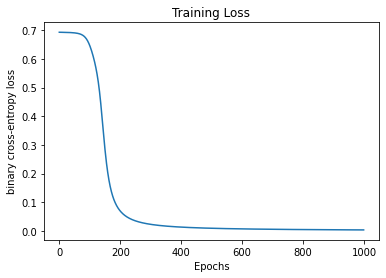

In [24]:
# initialize the parameters and get the data
weights, biases = get_parameters()
dataset = generate_data()

# train the network and plot the loss curve
losses = train(dataset,
               weights,
               biases,
               epochs=1000,
               lr=1,
               batch_size=4)
plot_loss(losses)

In [25]:
# Evaluate the network after training
predict(dataset, weights, biases)

Truth table predictions
_______________________
1 0 | 0.99749556549818
0 1 | 0.99256325635361
0 0 | 0.00324218901477
1 1 | 0.00194023302952


In [26]:
# Plot the surface of activations that the network learned
def plot_activation_surface(weights, biases, three_dim=False):

    X, Y = np.mgrid[0:1.1:0.1, 0:1.1:0.1]
    dataset = np.array([[x, y] for rowx, rowy in zip(Y, X) for x, y in zip(rowx, rowy)])
    
    _, activations, _ = feedforward(dataset, weights, biases)
    activation_grid = activations[-1].reshape(X.shape[0], Y.shape[0]).T
    
    if three_dim:
        ax = plt.axes(projection='3d')
        ax.view_init(50, 120)
        ax.plot_surface(X, Y, activation_grid, cmap='binary_r')
    else:
        plt.xlim(0, 10)
        plt.ylim(0, 10)
        plt.imshow(activation_grid, cmap='binary_r')

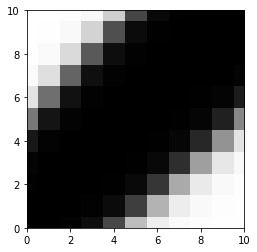

In [27]:
# plot 2d activation map
plot_activation_surface(weights, biases)

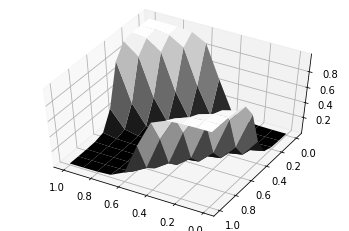

In [28]:
# plot 3d activation map
plot_activation_surface(weights, biases, three_dim=True)